# Hierarchical Conditionally Conjugate Finite Mixture Model
We don't want a dependency of the mean of each component on the covariance because it would make it hard to write a hierarchical model - specifically, the conditional posterior of the covariance hyperparameter of the mean.

To solve this problem, we drop conjugacy of the priors by setting the prior of the mean to be a Normal parametrized by two hyperparameters that do not depend on the covariance matrix.

In [1]:
import seaborn as sns
%matplotlib notebook

<IPython.core.display.Javascript object>


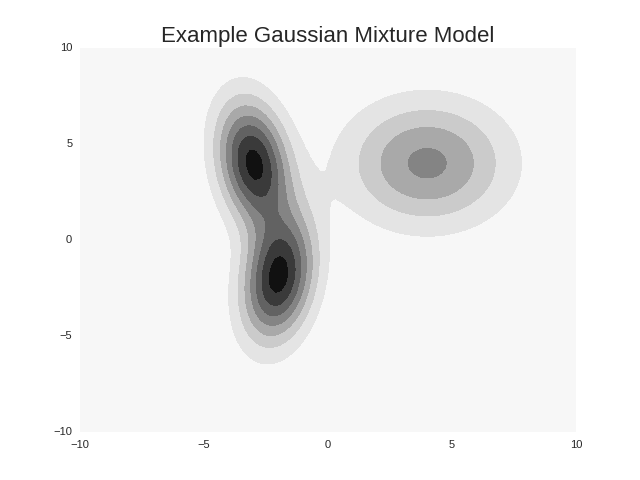

/usr/local/lib/python2.7/dist-packages/pypr/clustering/gmm.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pdf==None:


In [2]:
# Example GMM
from pypr.clustering import gmm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
pos = np.concatenate(pos, axis=0)

# Mean vector and covariance matrix
mix = np.array([0.3, 0.3, 0.4])
mu1 = np.array([-2, -2.])
mu2 = np.array([-3, 4.])
mu3 = np.array([4, 4])
Sigma = np.array([[ 1. , 0.5], [0.5,  5.]])
Sigma2 = np.array([[ 1. , -.5], [-.5,  5.]])
Sigma3 = np.array([[ 5. , 0], [0,  5.]])

# The distribution on the variables X, Y packed into pos.
fig = plt.figure()
ax = fig.gca()
plt.contourf(X, Y, gmm.gmm_pdf(pos, [mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mix).reshape(N, N))
plt.title('Example Gaussian Mixture Model', fontsize=20)
fig.canvas.draw()

<IPython.core.display.Javascript object>


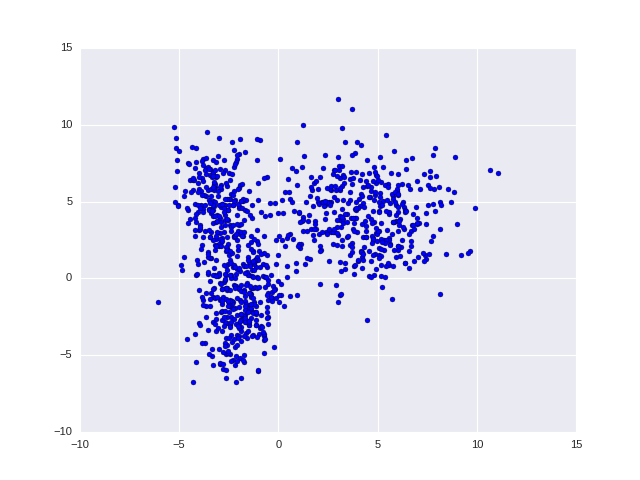

In [3]:
# Sample points from the real GMM and estimate a GMM for those points. Hopefully they will be the same!
N = 1000
d = 2
X = gmm.sample_gaussian_mixture([mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mc=mix, samples=N)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [4]:
X.shape

(1000, 2)

## The Mixture Model
Let's find a model that describes the generation process of these data. This model will be a **Bayesian Finite Gaussian Mixture Model**. This means it is a sum of $K$ weighted normal distributions (components) parametrized by their means and covariance matrices. Each point in the data set will belong to one of the gaussians.

The parameters we need to estimate are then: the cluster assignment of each data point, the mixture weights and the mean and covariance matrix of each component.

We assign priors to each of these parameters:
* Mixture weights $\mathbf{\pi} = [\pi_1, ..., \pi_K]$ are Dirichlet-distributed, with parameter vector $\mathbf{\alpha} = [\alpha/K, ..., \alpha/K]$;
* Cluster assignments $z_n$ assume values from $1$ to $K$ and are sampled from a discrete distribution with probabilities given by the mixture weights $\mathbf{\pi} = [\pi_1, ..., \pi_K]$;
* The joint prior distribution of the mean and covariance matrix of each component is a Normal-Inverse-Wishart distribution with hyperparameters $\{\mu_0, \lambda\}$ for the Normal, which is prior to the mean, and $\{\Psi, \upsilon\}$ for the inverse-Wishart, which is prior to the covariance matrix.

In [5]:
# Log likelihood
def log_likelihood(data, means, covs, pis):
    """Data log-likeliehood
    
    Equation 2.153 in Sudderth
    """
    ll = 0
    for i in range(data.shape[0]):
        probs = 0
        for k in range(K):
            probs = probs +  pis[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covs[k])
        ll = ll + np.log10(probs)
        
    return ll

In [6]:
# Resulting GMM
def plot_est_gmm(mu_est, cov_est, pi_est, fig_handler, title=None):
    N = 100
    x = np.linspace(-10, 10, N)
    y = np.linspace(-10, 10, N)
    x, y = np.meshgrid(x, y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pos = np.concatenate(pos, axis=0)

    z = gmm.gmm_pdf(pos, mu_est, cov_est, pi_est).reshape(N, N)

    # The distribution on the variables X, Y packed into pos.
    ax = fig_handler.gca()
    plt.contourf(x, y, z)
    if title == None:
        title = 'Estimated GMM'
    plt.title(title, fontsize=20)   
    fig_handler.canvas.draw()

In [7]:
K = 3 # number of clusters

# Hyperparameters
# Dirichlet
alpha = 100
alpha_arr = alpha * np.ones((K,))

# NIW
# need [mu0, lam, psi, ups] for each cluster k
mu0 = np.mean(X, axis=0).reshape(1, d)
lam = .2
psi = np.eye(d) * 1.5
ups = d

In [8]:
from scipy.stats import multivariate_normal, wishart, invgamma, invwishart, dirichlet, gamma

In [9]:
X_mean = np.mean(X, axis=0)
X_cov = np.cov(X.T)
X_cov_inv = np.linalg.inv(X_cov)

In [10]:
def prior_hyperparameters():
    mulinha = multivariate_normal.rvs(mean=X_mean, cov=X_cov)
    Sigmalinha = invwishart.rvs(df=d, scale=d * X_cov)
    Hlinha = wishart.rvs(df=d, scale=X_cov / d)
    sigmalinha = invgamma.rvs(1, 1/d) + d
    return mulinha, Sigmalinha, Hlinha, sigmalinha

def prior_mixture_components(mulinha, Sigmalinha, Hlinha, sigmalinha):
    mu = multivariate_normal.rvs(mean=mulinha, cov=Sigmalinha, size=K)
    cov_inv = wishart.rvs(df=sigmalinha, scale=np.linalg.inv(Hlinha), size=K)
    return mu, cov_inv

def prior_alpha():
    return invgamma.rvs(1, 1)

def prior_pi(alpha):
    return dirichlet.rvs(alpha/K * np.ones((K, ))).T

In [11]:
# Sampling from the conditional posteriors
def update_mixture_components(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha, z, nk):
    for k in range(K):
        X_k = X[np.argwhere(z==k).ravel()] # all the points in current cluster k
        
        Sigmaklinha_inv = np.linalg.inv(Sigmalinha) + nk[k]*cov_inv[k]
        Sigmaklinha = np.linalg.inv(Sigmaklinha_inv)
        muklinha = Sigmaklinha.dot(np.linalg.inv(Sigmalinha).dot(mulinha) + nk[k]*cov_inv[k].dot(np.mean(X_k, axis=0)))
        aux = np.matmul((X_k - mu[k]).T, (X_k - mu[k]))
        
        mu[k] = multivariate_normal.rvs(mean=muklinha, cov=Sigmaklinha)
        cov_inv[k] = wishart.rvs(df=int(np.ceil(sigmalinha)) + nk[k] + 1, scale=np.linalg.inv(Hlinha + aux))
    return mu, cov_inv

# the hyperparameters are the same for all mixture components
def update_hyperparameters(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha):
    # mulinha
    Sigmalinha_inv = np.linalg.inv(Sigmalinha)
    covariance = np.linalg.inv(X_cov_inv + K * Sigmalinha_inv)
    mean = covariance.dot(K**2 * Sigmalinha_inv.dot(np.mean(mu, axis=0)) + X_cov_inv.dot(X_mean))
    mulinha = multivariate_normal.rvs(mean=mean, cov=covariance)
    
    # Sigmalinha
    aux = np.matmul((mu - mulinha).T, mu - mulinha)
    Sigmalinha = np.linalg.inv(wishart.rvs(df=d+K, scale=np.linalg.inv(d*X_cov_inv + 2*aux)))
    
    # Hlinha
    Hlinha = invwishart.rvs(df=d + K*sigmalinha, scale=d*X_cov_inv + np.sum(cov_inv, axis=0))
    
    # sigmalinha
    sigmalinha = invgamma.rvs(1, 1/d)
    
    return mulinha, Sigmalinha, Hlinha, sigmalinha 

def update_alpha():
    return invgamma.rvs(1, 1)

def update_pi(alpha, nk):
    return dirichlet.rvs(alpha/K * np.ones((K, )) + nk).T

In [12]:
def cluster_probs_at_point(x, means, cov_invs, pis):
    probs = [(pis[k] * multivariate_normal.pdf(x, mean=means[k], cov=np.linalg.inv(cov_invs[k]))) for k in range(K)]
    probs = probs / np.sum(probs)
    return probs

def update_z(mu, cov_inv, pi):
    for n in range(N):
        probs = np.array(cluster_probs_at_point(X[n], mu, cov_inv, pi)).ravel()
        z[n] = np.random.choice(range(K), p=probs)
    return z

def update_counts(z):
    for k in range(K):
        nk[k] = 0
        for n in range(N):
            if z[n] == k:
                nk[k] += 1
    return nk

In [13]:
# Assignment vector: N x 1
z = np.zeros((N,))

# Number of data points per cluster:
nk = np.zeros((K,))

# Mixture weights vector: K x 1
pi = np.zeros((K,))

# Mean vector: K x d
mu = np.zeros((K, d))

# Covariance matrix: K x d x d
cov_inv = np.zeros((K, d, d))

<IPython.core.display.Javascript object>


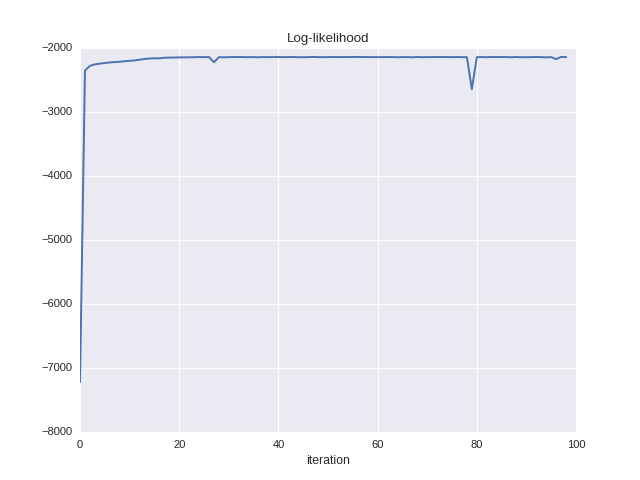

<IPython.core.display.Javascript object>


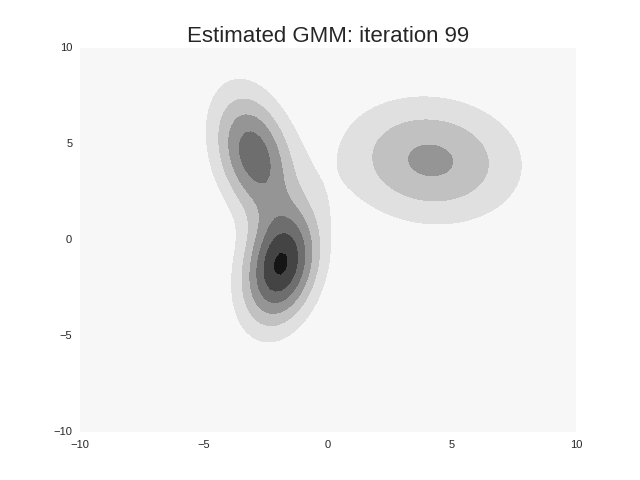

In [14]:
z_runlist = []
pi_runlist = []
mu_runlist = []
cov_inv_runlist = []

save_plot = False
path = 'figures/'

fig1 = plt.figure(4)
ax = fig1.add_subplot(111)
plt.ion() 
fig1.show()
fig1.canvas.draw()

fig2 = plt.figure(5)
ax = fig2.add_subplot(111)
plt.ion() 
fig2.show()
fig2.canvas.draw()

# Gibbs sampling iterations
niterations = 100

# Keep track of the log-likelihood of the estimated model during sampling
lls = np.ones((niterations, 1))

# Initialize parameters with samples from the prior distributions
# the hyperparameters are the same for all mixture components
mulinha, Sigmalinha, Hlinha, sigmalinha = prior_hyperparameters()  
mu, cov_inv = prior_mixture_components(mulinha, Sigmalinha, Hlinha, sigmalinha)  
alpha = prior_alpha()
pi = prior_pi(alpha)
z = update_z(mu, cov_inv, pi)
nk = update_counts(z)

for i in range(0, niterations):
#     print('\nIteration %d' % i)
#     print('nk', nk)
#     print('pi', pi)
#     print('mu', mu)
#     print('cov', np.linalg.inv(cov_inv))
    lls[i] = log_likelihood(X, mu, np.linalg.inv(cov_inv), pi)
    
    plt.figure(4)
    plt.gcf().clear()
    plt.plot(lls[:i])
    plt.xlabel("iteration")
    plt.title('Log-likelihood')
    fig1.canvas.draw()
    
    plt.figure(5)
    plt.gcf().clear()
    plot_est_gmm(mu, np.linalg.inv(cov_inv), pi, fig2, title='Estimated GMM: iteration ' + str(i))
    if save_plot:
        plt.savefig(path + str(i) + '.jpg')    

    # Sampling from the conditional posteriors
    z = update_z(mu, cov_inv, pi)
    nk = update_counts(z)
    
    alpha = update_alpha()
    pi = update_pi(alpha, nk)
    
    # the hyperparameters are the same for all mixture components
    mulinha, Sigmalinha, Hlinha, sigmalinha = update_hyperparameters(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha)    
    
    mu, cov_inv = update_mixture_components(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha, z, nk)
    
    z_runlist.append(z)
    pi_runlist.append(pi)
    mu_runlist.append(mu)
    cov_inv_runlist.append(cov_inv)

In [15]:
# Estimate parameter from samples
def gibbs_estimate(samples, n_burnin=30):
    n_samples = len(samples)
    estimate = np.sum(samples[n_burnin:], axis=0) / (n_samples - n_burnin)
    return estimate

<IPython.core.display.Javascript object>


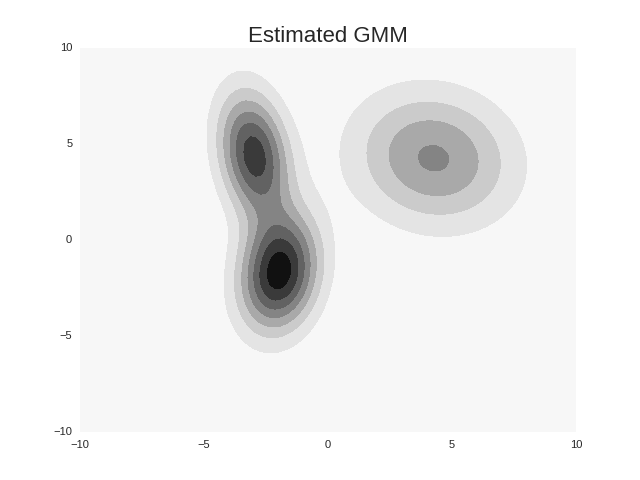

In [16]:
# Estimate the true parameters from the samples
z_est = gibbs_estimate(z_runlist)
pi_est = gibbs_estimate(pi_runlist)
mu_est = gibbs_estimate(mu_runlist)
cov_est = np.linalg.inv(gibbs_estimate(cov_inv_runlist))

fig = plt.figure()
plot_est_gmm(mu_est, cov_est, pi_est, fig)